In [1]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

In [1]:
import bt #백테스팅
import yfinance as yf #주가크롤링

import pandas as pd

### 주가 데이터 로드

In [2]:
# 백테스팅 날짜 선정
start = '2015-01-01'
end = '2020-12-31'

In [3]:
symbol = ['XLF', 'XLY', 'XLP', 'XLK', 'XLV']
# 금융, 임의소비재, 필수소비재, 정보기술, 헬스케어

df = yf.download(symbol, start, end)
df = df['Adj Close']
df

[*********************100%***********************]  5 of 5 completed


Ticker,XLF,XLK,XLP,XLV,XLY
Date,,,,,
2015-01-02 00:00:00+00:00,16.656864,36.498821,37.333603,58.564087,64.070145
2015-01-05 00:00:00+00:00,16.306618,35.941658,37.071060,58.265419,62.844730
2015-01-06 00:00:00+00:00,16.057400,35.508305,37.024738,58.069160,62.218582
2015-01-07 00:00:00+00:00,16.225796,35.809002,37.657898,59.434486,63.202515
2015-01-08 00:00:00+00:00,16.468273,36.596100,38.229286,60.449940,64.150642
...,...,...,...,...,...
2020-12-23 00:00:00+00:00,26.999994,124.272270,60.260098,104.894234,152.933319
2020-12-24 00:00:00+00:00,27.037354,125.096146,60.559628,105.196213,153.253662
2020-12-28 00:00:00+00:00,27.168110,126.511330,61.040699,105.460449,155.000916


<Axes: xlabel='Date'>

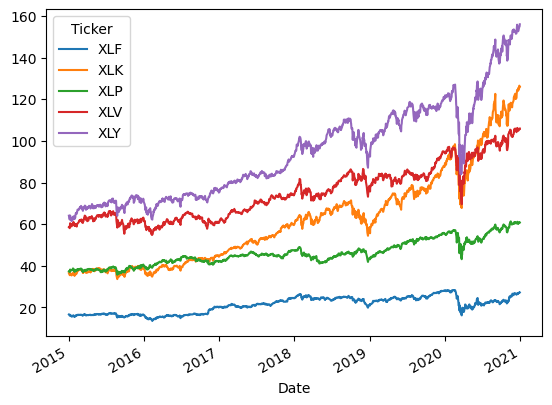

In [4]:
df.plot()

---

In [23]:
import bt
import yfinance as yf
import pandas as pd
import numpy as np

# 1. 금리 데이터와 비중 데이터 로드
interest_rate_df = pd.read_csv('/Users/leesangwon/Downloads/미국_금리.csv', parse_dates=['날짜'])
weight_df = pd.read_csv('/Users/leesangwon/Downloads/비중_지표_예.csv')

# 금리 데이터 날짜를 DateTime 형식으로 변환
interest_rate_df['날짜'] = pd.to_datetime(interest_rate_df['날짜'], format='%Y.%m.%d')

# 2. 야후파이낸스 데이터 다운로드 (예시: 주식, 채권, 원자재)
tickers = ['SPY', 'TLT', 'DBC']  # SPY: S&P 500, TLT: 미국 장기채권, DBC: 원자재
prices = yf.download(tickers, start='2010-01-01', end='2023-12-31')['Adj Close']

# 3. 금리 변동 이벤트 감지 및 비중 조정
def adjust_weights(target):
    # 현재 날짜를 타겟 객체에서 직접 가져오기 (target.now는 pd.Timestamp 객체)
    current_date = target.now.date()
    
    # 금리가 변동한 날짜를 찾고, 해당 날짜의 비중을 가져옴
    rate_change = interest_rate_df[interest_rate_df['날짜'] == pd.to_datetime(current_date)]
    
    if not rate_change.empty:
        # 금리 변동에 따라 비중을 조정 (예: 금리가 높으면 채권 비중 증가, 낮으면 주식 비중 증가)
        weight_row = weight_df[weight_df['금리변동'] == rate_change['금리'].values[0]]
        if not weight_row.empty:
            weights = weight_row[['채권 비중', '주식 비중', '원자재 비중']].values[0]
            # 비중을 pandas Series 형식으로 반환
            target.temp['weights'] = pd.Series(weights, index=prices.columns)  # 임시 저장
            return pd.Series(weights, index=prices.columns)
    
    # 금리가 변동하지 않으면 이전 비중을 그대로 유지
    return target.temp['weights'] if 'weights' in target.temp else pd.Series([0.33, 0.33, 0.33], index=prices.columns)

# 4. 전략 설정: 매일 실행되고 금리 변동이 있는 날에만 비중 조정
def backtest_strategy():
    # 전략의 초기 비중 설정 (기본적으로 균등 비중)
    initial_weights = pd.Series([0.33, 0.33, 0.33], index=prices.columns)

    # 전략 포트폴리오 생성
    strategy = bt.Strategy('Dynamic Allocation with Rate Change',
                           [
                               bt.algos.RunDaily(),  # 매일 실행
                               bt.algos.SelectAll(),
                               bt.algos.WeighTarget(adjust_weights),  # 금리 변동에 따라 비중 조정
                               bt.algos.Rebalance()
                           ])

    # 백테스팅 포트폴리오 생성
    portfolio = bt.Backtest(strategy, prices)

    return portfolio

# 5. 백테스팅 실행
portfolio = backtest_strategy()
result = bt.run(portfolio)

# 결과 출력
result.plot()

[*********************100%***********************]  3 of 3 completed
  0%|          | 0/1 [00:00<?, ?it/s]


KeyError: <function adjust_weights at 0x301191440>